# Import PreReqs

In [21]:
import boto3
import sagemaker
import pandas as pd
from pyathena import connect

In [22]:
%store -r

In [35]:
%store

Stored variables and their in-db values:
catalog_df                                        ->   sample_id img_filename label_filename
0    00001
ingest_create_athena_table_csv_passed             -> True
path_raw_data                                     -> './data'
path_s3_catalog                                   -> 's3://sagemaker-us-east-1-339129315232/safety/cata
path_s3_data                                      -> 's3://sagemaker-us-east-1-339129315232/safety/data
s3_staging_dir                                    -> 's3://sagemaker-us-east-1-339129315232/athena/stag
setup_dependencies_passed                         -> True
setup_s3_bucket_passed                            -> True


In [97]:
# Set up AWS configurations
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
boto_session = boto3.Session(region_name=region)
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

In [93]:
#Creating Bucket
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = "sagemaker-assignment-3"

print(default_s3_bucket_name)

sagemaker-us-east-1-339129315232


In [37]:
# Define connection parameters
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [38]:
# Define statement to show existing databases
show_databases_statement = "SHOW DATABASES"

# Execute and display resulting dataframe
df_show_databases = pd.read_sql(show_databases_statement, conn)
df_show_databases.head(10)

/tmp/ipykernel_2166/2410389507.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show_databases = pd.read_sql(show_databases_statement, conn)


,database_name
0,default
1,dsoaws1
2,safetydb
3,sagemaker_featurestore


## EDA

In [42]:
import os
import pandas as pd

# Assuming 'catalog_df' is your DataFrame with sample IDs, image filenames, and label filenames
label_folder = 'data/labels'  # Replace with the path to your label folder
image_folder = 'data/images'  # Replace with the path to your image folder

# Load label data
label_data = []

for index, row in catalog_df.iterrows():
    label_filename = os.path.join(label_folder, row['label_filename'])
    
    with open(label_filename, 'r') as file:
        label_content = file.read().strip().split()  # Split content into numerical values
        label_values = [float(value) for value in label_content]  # Convert to floats
        label_data.append({'sample_id': row['sample_id'], 'label_values': label_values})

# Create label DataFrame
labels_df = pd.DataFrame(label_data)

# Load image data
image_data = []

for index, row in catalog_df.iterrows():
    image_filename = os.path.join(image_folder, row['img_filename'])
    image_data.append({'sample_id': row['sample_id'], 'image_filename': row['img_filename'], 'image_path': image_filename})

# Create image DataFrame
images_df = pd.DataFrame(image_data)

# Merge label and image DataFrames
merged_df = pd.merge(images_df, labels_df, on='sample_id', how='inner')

# Display the merged DataFrame
merged_df.head()


,sample_id,image_filename,image_path,label_values
0,000015,000015.jpg,data/images/000015.jpg,"[0.0, 0.9625, 0.701562, 0.053125, 0.103125, 0...."
1,000016,000016.jpg,data/images/000016.jpg,"[0.0, 0.370312, 0.225, 0.184375, 0.25625]"
2,000017,000017.jpg,data/images/000017.jpg,"[0.0, 0.33400001586414874, 0.3693693783134222,..."
3,000018,000018.jpg,data/images/000018.jpg,"[0.0, 0.291406, 0.171875, 0.045312, 0.08125, 1..."
4,000019,000019.jpg,data/images/000019.jpg,"[2.0, 0.6712499849963933, 0.33146067755296826,..."


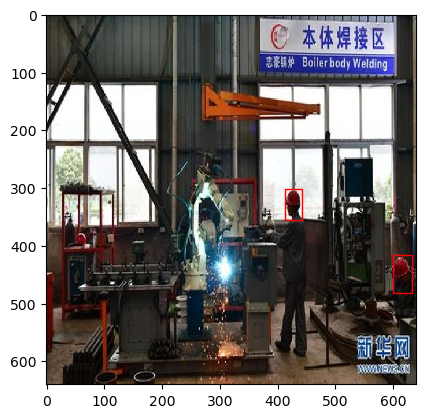

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize_bounding_boxes(image_path, label_values):
    img = Image.open(image_path)
    img_array = plt.imread(image_path)

    # Get image aspect ratio
    img_height, img_width, _ = img_array.shape
    aspect_ratio = img_width / img_height

    plt.imshow(img)

    ax = plt.gca()
    num_boxes = len(label_values) // 5  # Assuming each bounding box has 5 values (class, x, y, width, height)

    for i in range(num_boxes):
        idx = i * 5
        label = label_values[idx:idx + 5]
        class_id, x, y, width, height = label

        # Scale and position bounding box
        x *= img_width
        y *= img_height
        width *= img_width
        height *= img_height

        # Calculate upper-left coordinates
        x_upper_left = x - (width / 2)
        y_upper_left = y - (height / 2)

        rect = patches.Rectangle((x_upper_left, y_upper_left), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.set_aspect('equal', adjustable='box')
    plt.show()

# Visualize bounding boxes for a specific sample
visualize_bounding_boxes(merged_df['image_path'][0], merged_df['label_values'][0])


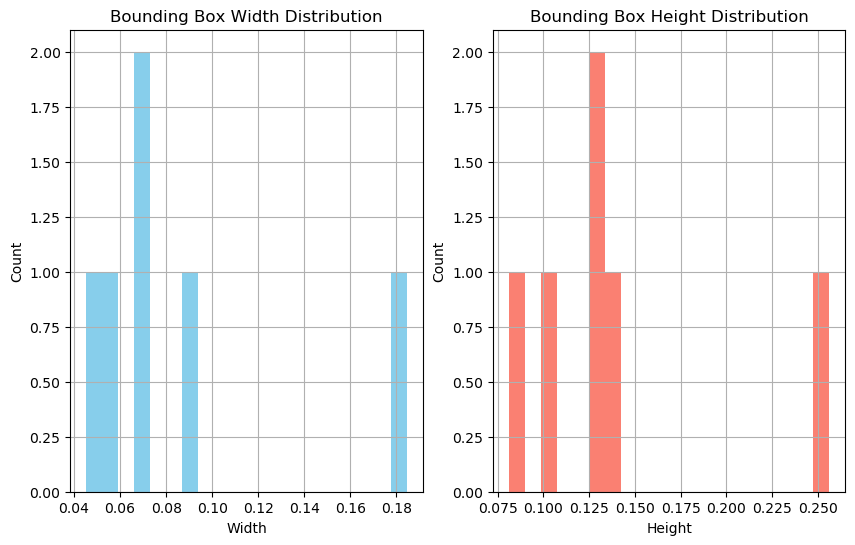

In [48]:
merged_df['bbox_width'] = merged_df['label_values'].apply(lambda x: x[3])
merged_df['bbox_height'] = merged_df['label_values'].apply(lambda x: x[4])

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
merged_df['bbox_width'].hist(bins=20, color='skyblue')
plt.title('Bounding Box Width Distribution')
plt.xlabel('Width')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
merged_df['bbox_height'].hist(bins=20, color='salmon')
plt.title('Bounding Box Height Distribution')
plt.xlabel('Height')
plt.ylabel('Count')

plt.show()

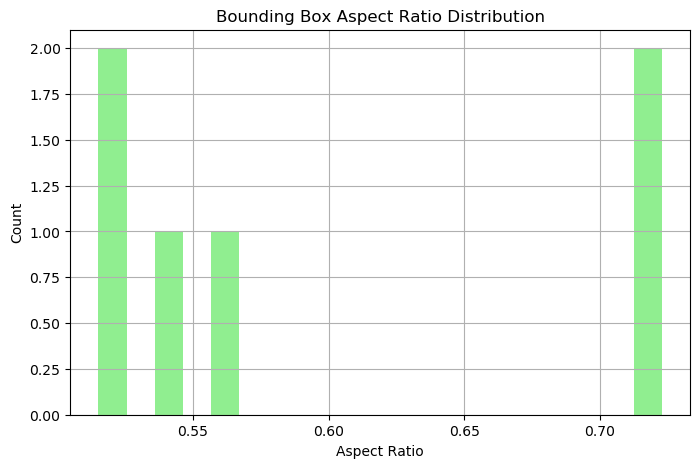

In [49]:
merged_df['bbox_aspect_ratio'] = merged_df['bbox_width'] / merged_df['bbox_height']

plt.figure(figsize=(8, 5))
merged_df['bbox_aspect_ratio'].hist(bins=20, color='lightgreen')
plt.title('Bounding Box Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Count')
plt.show()

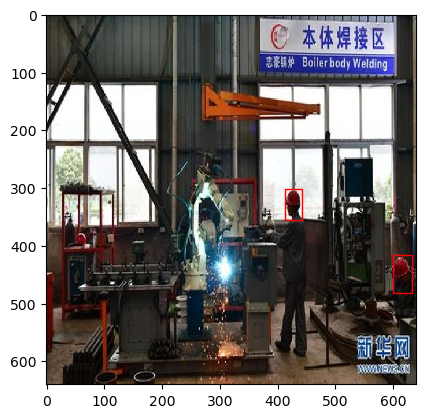

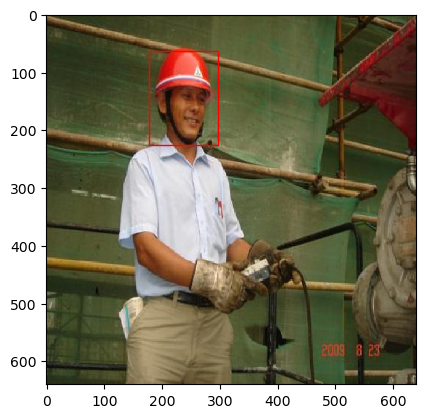

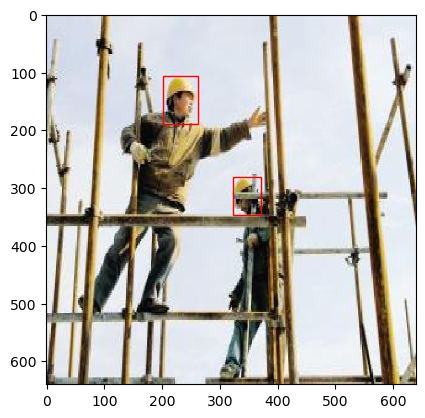

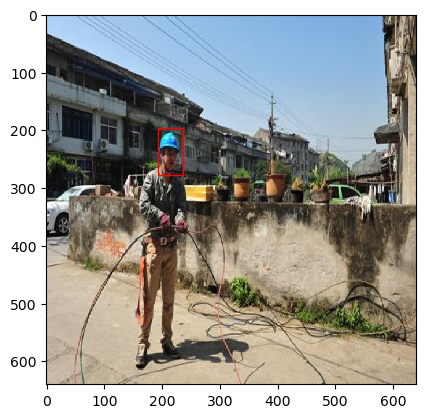

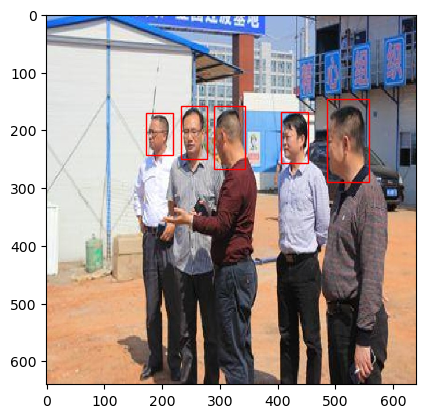

In [50]:
import random

# Randomly select and visualize images with bounding boxes
random_samples = merged_df.sample(n=5, random_state=42)
for index, row in random_samples.iterrows():
    visualize_bounding_boxes(row['image_path'], row['label_values'])


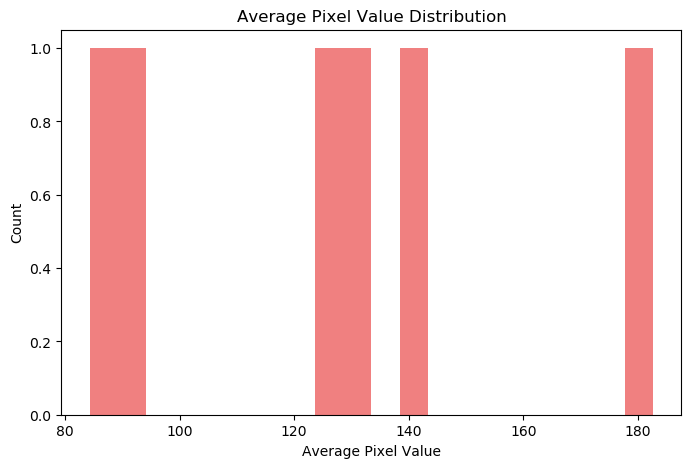

In [52]:
average_pixel_values = []
for index, row in merged_df.iterrows():
    image_array = plt.imread(row['image_path'])
    average_pixel_values.append(image_array.mean())

plt.figure(figsize=(8, 5))
plt.hist(average_pixel_values, bins=20, color='lightcoral')
plt.title('Average Pixel Value Distribution')
plt.xlabel('Average Pixel Value')
plt.ylabel('Count')
plt.show()


# Feature Engineering

#### Bounding Box Area

In [53]:
merged_df['bbox_area'] = merged_df['bbox_width'] * merged_df['bbox_height']

#### Bounding Box Normalization

In [54]:
merged_df['normalized_x'] = merged_df['label_values'].apply(lambda x: x[1])
merged_df['normalized_y'] = merged_df['label_values'].apply(lambda x: x[2])
merged_df['normalized_width'] = merged_df['label_values'].apply(lambda x: x[3])
merged_df['normalized_height'] = merged_df['label_values'].apply(lambda x: x[4])

#### Aspect Ratio Encoding

In [55]:
merged_df['aspect_ratio_encoding'] = merged_df['bbox_width'] / merged_df['bbox_height']

##### Bounding Box Density

In [59]:
# Assuming 'image_path' is a column in your DataFrame
merged_df['img_dimensions'] = merged_df['image_path'].apply(lambda path: Image.open(path).size)

In [60]:
# Unpack the dimensions tuple into separate columns
merged_df[['img_width', 'img_height']] = pd.DataFrame(merged_df['img_dimensions'].tolist(), index=merged_df.index)

In [61]:
# 4. Bounding Box Density
merged_df['bbox_density'] = merged_df['bbox_area'] / (merged_df['img_width'] * merged_df['img_height'])

In [62]:
# Clean up: Drop the temporary 'img_dimensions' column
merged_df = merged_df.drop('img_dimensions', axis=1)

##### Spatial Features

In [66]:
merged_df['bbox_center_x'] = merged_df['normalized_x'] + merged_df['normalized_width'] / 2
merged_df['bbox_center_y'] = merged_df['normalized_y'] + merged_df['normalized_height'] / 2

merged_df['distance_to_image_center'] = ((merged_df['bbox_center_x'] - 0.5) ** 2 + (merged_df['bbox_center_y'] - 0.5) ** 2) ** 0.5

#### Timestamp

In [75]:
from datetime import datetime

# Assuming 'merged_df' is your DataFrame
merged_df['timestamp'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

In [76]:
merged_df

,sample_id,image_filename,image_path,label_values,class,bbox_width,bbox_height,bbox_aspect_ratio,bbox_area,normalized_x,...,normalized_width,normalized_height,aspect_ratio_encoding,img_width,img_height,bbox_density,bbox_center_x,bbox_center_y,distance_to_image_center,timestamp
0,000015,000015.jpg,data/images/000015.jpg,"[0.0, 0.9625, 0.701562, 0.053125, 0.103125, 0....",0.0,0.053125,0.103125,0.515152,0.005479,0.962500,...,0.053125,0.103125,0.515152,640,640,1.337528e-08,0.989063,0.753124,0.550685,2024-01-30 06:19:56
1,000016,000016.jpg,data/images/000016.jpg,"[0.0, 0.370312, 0.225, 0.184375, 0.25625]",0.0,0.184375,0.256250,0.719512,0.047246,0.370312,...,0.184375,0.256250,0.719512,640,640,1.153469e-07,0.462499,0.353125,0.151587,2024-01-30 06:19:56
2,000017,000017.jpg,data/images/000017.jpg,"[0.0, 0.33400001586414874, 0.3693693783134222,...",0.0,0.068000,0.126126,0.539143,0.008577,0.334000,...,0.068000,0.126126,0.539143,640,640,2.093891e-08,0.368000,0.432432,0.148288,2024-01-30 06:19:56
3,000018,000018.jpg,data/images/000018.jpg,"[0.0, 0.291406, 0.171875, 0.045312, 0.08125, 1...",0.0,0.045312,0.081250,0.557686,0.003682,0.291406,...,0.045312,0.081250,0.557686,640,640,8.988281e-09,0.314062,0.212500,0.342387,2024-01-30 06:19:56
4,000019,000019.jpg,data/images/000019.jpg,"[2.0, 0.6712499849963933, 0.33146067755296826,...",2.0,0.072500,0.138577,0.523176,0.010047,0.671250,...,0.072500,0.138577,0.523176,640,640,2.452836e-08,0.707500,0.400749,0.230015,2024-01-30 06:19:56
5,000020,000020.jpg,data/images/000020.jpg,"[0.0, 0.3625, 0.230469, 0.09375, 0.129688, 0.0...",0.0,0.093750,0.129688,0.722889,0.012158,0.362500,...,0.093750,0.129688,0.722889,640,640,2.968323e-08,0.409375,0.295313,0.223852,2024-01-30 06:19:56


## Feature Store

In [69]:
import sagemaker
from sagemaker.session import Session

# Initialize SageMaker Feature Store client
feature_store_session = Session()
feature_store_runtime = sagemaker.Session()

In [72]:
from sagemaker import get_execution_role

# You can modify the following to use a role of your choosing. See the documentation for how to create this.
role = get_execution_role()
print(role)

arn:aws:iam::339129315232:role/LabRole


In [70]:
merged_df.dtypes

sample_id                    object
image_filename               object
image_path                   object
label_values                 object
class                       float64
bbox_width                  float64
bbox_height                 float64
bbox_aspect_ratio           float64
bbox_area                   float64
normalized_x                float64
normalized_y                float64
normalized_width            float64
normalized_height           float64
aspect_ratio_encoding       float64
img_width                     int64
img_height                    int64
bbox_density                float64
bbox_center_x               float64
bbox_center_y               float64
distance_to_image_center    float64
dtype: object

In [79]:
#Setting the feature group name. 
from time import gmtime, strftime, sleep

job_safety_feature_group_name = "neighborhood-feature-group-" + strftime("%d-%H-%M-%S", gmtime())

In [80]:
#Creating the Feature Group
from sagemaker.feature_store.feature_group import FeatureGroup

job_safety_feature_group = FeatureGroup(
    name=job_safety_feature_group_name, sagemaker_session=feature_store_session
)

In [87]:
from sagemaker.feature_store.feature_definition import FeatureDefinition, FeatureTypeEnum

# Define the feature definitions
feature_definitions = [
    FeatureDefinition(feature_name='sample_id', feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name='image_filename', feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name='label_values', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='class', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='bbox_width', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='bbox_height', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='bbox_aspect_ratio', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='bbox_area', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='normalized_x', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='normalized_y', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='normalized_width', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='normalized_height', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='aspect_ratio_encoding', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='img_width', feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name='img_height', feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name='bbox_density', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='bbox_center_x', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='bbox_center_y', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='distance_to_image_center', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='timestamp', feature_type=FeatureTypeEnum.FRACTIONAL),  # Adjust the type accordingly
]

In [91]:
#Importing feature definitions to feature group
import time

current_time_sec = int(round(time.time()))


def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")


# casting the object dtype to string. 
cast_object_to_string(merged_df)

# recording the identifier and event time feature names
record_identifier_feature_name = "sample_id"
event_time_feature_name = "timestamp"

# Appending the EventTime feature
merged_df[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(merged_df), dtype="float64"
)

# loading feature definitions to the feature group.
job_safety_feature_group.load_feature_definitions(data_frame=merged_df)
# output is suppressed

[FeatureDefinition(feature_name='sample_id', feature_type=<FeatureTypeEnum.STRING: 'String'>),
 FeatureDefinition(feature_name='image_filename', feature_type=<FeatureTypeEnum.STRING: 'String'>),
 FeatureDefinition(feature_name='image_path', feature_type=<FeatureTypeEnum.STRING: 'String'>),
 FeatureDefinition(feature_name='label_values', feature_type=<FeatureTypeEnum.STRING: 'String'>),
 FeatureDefinition(feature_name='class', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='bbox_width', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='bbox_height', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='bbox_aspect_ratio', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='bbox_area', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='normalized_x', feature_type=<FeatureTypeEnum.FRACTIONAL:

#### Create FeatureGroups in SageMaker FeatureStore

In [94]:
#Creating the feature Group
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")


job_safety_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

wait_for_feature_group_creation_complete(feature_group=job_safety_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup neighborhood-feature-group-30-06-22-40 successfully created.


In [95]:
#Describing the Feature Group
job_safety_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:339129315232:feature-group/neighborhood-feature-group-30-06-22-40',
 'FeatureGroupName': 'neighborhood-feature-group-30-06-22-40',
 'RecordIdentifierFeatureName': 'sample_id',
 'EventTimeFeatureName': 'timestamp',
 'FeatureDefinitions': [{'FeatureName': 'sample_id', 'FeatureType': 'String'},
  {'FeatureName': 'image_filename', 'FeatureType': 'String'},
  {'FeatureName': 'image_path', 'FeatureType': 'String'},
  {'FeatureName': 'label_values', 'FeatureType': 'String'},
  {'FeatureName': 'class', 'FeatureType': 'Fractional'},
  {'FeatureName': 'bbox_width', 'FeatureType': 'Fractional'},
  {'FeatureName': 'bbox_height', 'FeatureType': 'Fractional'},
  {'FeatureName': 'bbox_aspect_ratio', 'FeatureType': 'Fractional'},
  {'FeatureName': 'bbox_area', 'FeatureType': 'Fractional'},
  {'FeatureName': 'normalized_x', 'FeatureType': 'Fractional'},
  {'FeatureName': 'normalized_y', 'FeatureType': 'Fractional'},
  {'FeatureName': 'normalized_width', 

In [98]:
#Listing Feature Groups
sagemaker_client.list_feature_groups()  # use boto client to list FeatureGroups

{'FeatureGroupSummaries': [{'FeatureGroupName': 'neighborhood-feature-group-30-06-22-40',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:339129315232:feature-group/neighborhood-feature-group-30-06-22-40',
   'CreationTime': datetime.datetime(2024, 1, 30, 6, 33, 49, 841000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created'},
  {'FeatureGroupName': 'neighborhood-feature-group-27-09-02-30',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:339129315232:feature-group/neighborhood-feature-group-27-09-02-30',
   'CreationTime': datetime.datetime(2024, 1, 27, 9, 2, 36, 197000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created',
   'OfflineStoreStatus': {'Status': 'Active'}},
  {'FeatureGroupName': 'neighborhood-feature-group-27-08-14-47',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:339129315232:feature-group/neighborhood-feature-group-27-08-14-47',
   'CreationTime': datetime.datetime(2024, 1, 27, 8, 15, 27, 276000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created',
   

#### PutRecords into FeatureGroup

In [100]:
# Ingesting the data
job_safety_feature_group.ingest(data_frame=merged_df, max_workers=3, wait=True)

IngestionManagerPandas(feature_group_name='neighborhood-feature-group-30-06-22-40', sagemaker_session=<sagemaker.session.Session object at 0x7fbb084eece0>, data_frame=  sample_id image_filename              image_path  \
0    000015     000015.jpg  data/images/000015.jpg   
1    000016     000016.jpg  data/images/000016.jpg   
2    000017     000017.jpg  data/images/000017.jpg   
3    000018     000018.jpg  data/images/000018.jpg   
4    000019     000019.jpg  data/images/000019.jpg   
5    000020     000020.jpg  data/images/000020.jpg   

                                        label_values  class  bbox_width  \
0  [0.0, 0.9625, 0.701562, 0.053125, 0.103125, 0....    0.0    0.053125   
1          [0.0, 0.370312, 0.225, 0.184375, 0.25625]    0.0    0.184375   
2  [0.0, 0.33400001586414874, 0.3693693783134222,...    0.0    0.068000   
3  [0.0, 0.291406, 0.171875, 0.045312, 0.08125, 1...    0.0    0.045312   
4  [2.0, 0.6712499849963933, 0.33146067755296826,...    2.0    0.072500   
5  [